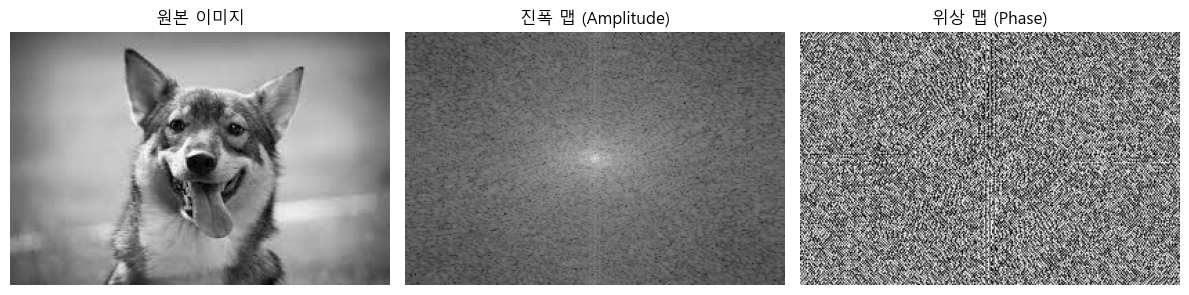

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy.fftpack import fft2, fftshift

# 한글 사용하기 위한 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

image1 = Image.open('dog.jpg').convert('L')
image2 = Image.open('please.jpg').convert('L')

# 2D FFT 수행
fft_image1 = fft2(image1)

# 주파수 스펙트럼 시프트
fft_shifted1 = fftshift(fft_image1)

# 진폭(amplitude) 계산 (복소수 크기)
amplitude1 = np.abs(fft_shifted1)

# 위상(phase) 계산 (복소수의 각도)
phase1 = np.angle(fft_shifted1)

# 진폭과 위상 맵 시각화
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(image1, cmap='gray')
plt.title('원본 이미지')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.log1p(amplitude1), cmap='gray')
plt.title('진폭 맵 (Amplitude)')
plt.axis('off')

plt.subplot(133)
plt.imshow(phase1, cmap='gray')
plt.title('위상 맵 (Phase)')
plt.axis('off')

plt.tight_layout()
plt.show()


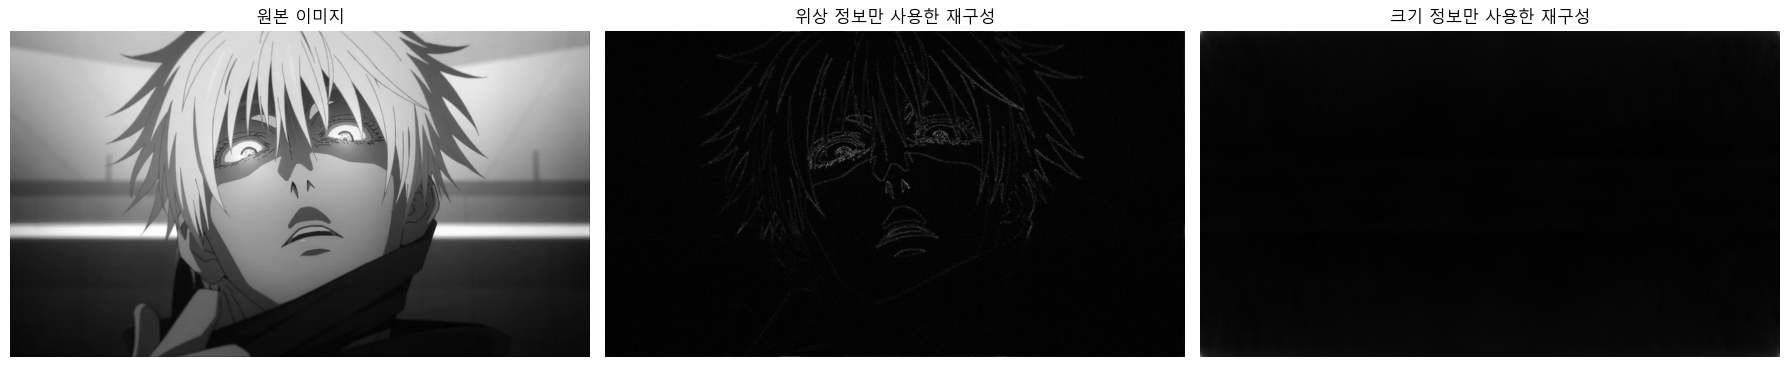

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage.color import rgb2gray
from skimage.io import imread

# 이미지 로드 및 회색조 변환
image = imread('please.jpg')
gray_image = rgb2gray(image)

# 2D FFT 수행
fft_image = fft2(gray_image)
fft_shifted = fftshift(fft_image)

# 진폭과 위상 계산
magnitude = np.abs(fft_shifted)
phase = np.angle(fft_shifted)

# 위상만을 사용한 재구성 (크기 정보를 무시)
reconstructed_phase_only = np.abs(ifft2(ifftshift(np.exp(1j * phase))))

# 크기만을 사용한 재구성 (위상 정보를 무시)
reconstructed_magnitude_only = np.abs(ifft2(ifftshift(magnitude)))

# 원본 이미지, 위상 재구성 이미지, 크기 재구성 이미지 시각화
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(gray_image, cmap='gray')
plt.title('원본 이미지')
plt.axis('off')

plt.subplot(132)
plt.imshow(reconstructed_phase_only, cmap='gray')
plt.title('위상 정보만 사용한 재구성')
plt.axis('off')

plt.subplot(133)
plt.imshow(reconstructed_magnitude_only, cmap='gray')
plt.title('크기 정보만 사용한 재구성')
plt.axis('off')

plt.tight_layout()
plt.show()


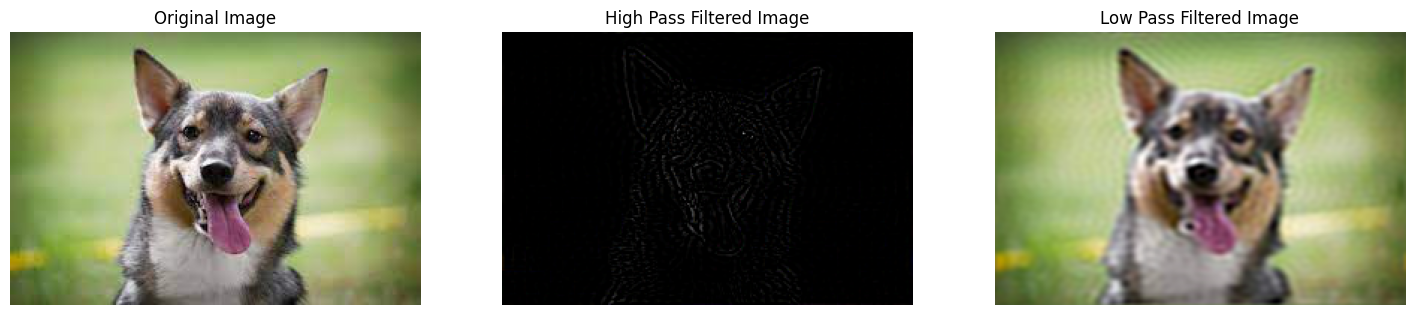

In [186]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 로드
image_path = 'dog.jpg'
image = Image.open(image_path).convert('RGB')  # 이미지를 컬러로 로드

# 이미지 텐서로 변환
transform = transforms.ToTensor()
x = transform(image).unsqueeze(0)  # 배치 차원 추가

# FFT 적용
x_fft = torch.fft.fft2(x, dim=(2, 3))
x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

# 마스크 생성
rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
center_row, center_col = rows // 2, cols // 2
cutoff_frequency = min(rows, cols) // 5

high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)

y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

high_pass_mask[:, :, dist <= cutoff_frequency] = 0
low_pass_mask[:, :, dist <= cutoff_frequency] = 1

# 고주파 및 저주파 필터링
high_pass = x_fft_shifted * high_pass_mask
low_pass = x_fft_shifted * low_pass_mask

# IFFT 적용
high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real

# 텐서를 이미지로 변환
high_pass_ifft = torch.clamp(high_pass_ifft, 0, 1)  # 값 범위를 [0, 1]로 클램핑
low_pass_ifft = torch.clamp(low_pass_ifft, 0, 1)    # 값 범위를 [0, 1]로 클램핑

high_pass_image = transforms.ToPILImage()(high_pass_ifft.squeeze(0))

low_pass_image = transforms.ToPILImage()(low_pass_ifft.squeeze(0))

high_pass_mask_image = transforms.ToPILImage()(low_pass_ifft.squeeze(0))

x_fft_shifted_image = transforms.ToPILImage()(abs(x_fft_shifted).squeeze(0))
# 결과 시각화
plt.figure(figsize=(18, 6))

# 원본 이미지 시각화
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# 고주파 필터링 결과 시각화
plt.subplot(1, 3, 2)
plt.title("High Pass Filtered Image")
plt.imshow(high_pass_image)
plt.axis('off')

# 저주파 필터링 결과 시각화
plt.subplot(1, 3, 3)
plt.title("Low Pass Filtered Image")
plt.imshow(low_pass_image)
plt.axis('off')

plt.show()


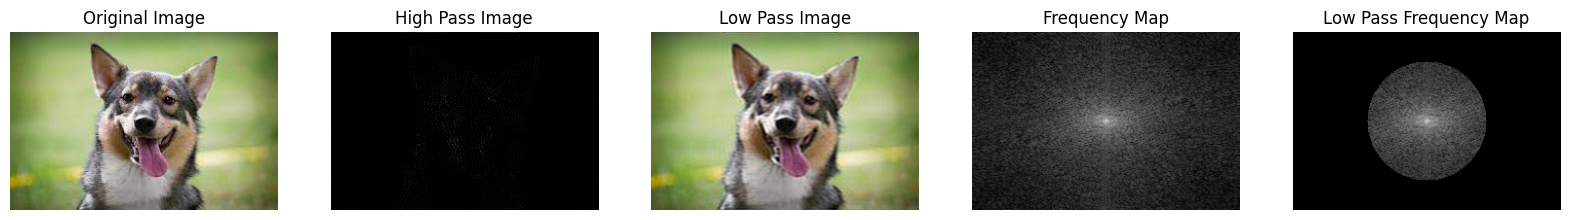

In [201]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 이미지 로드
image_path = 'dog.jpg'
image = Image.open(image_path).convert('RGB')  # 이미지를 컬러로 로드

# 이미지 텐서로 변환
transform = transforms.ToTensor()
x = transform(image).unsqueeze(0)  # 배치 차원 추가

# FFT 적용
x_fft = torch.fft.fft2(x, dim=(2, 3))
x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

# 마스크 생성
rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
center_row, center_col = rows // 2, cols // 2
cutoff_frequency = min(rows, cols) // 3

high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)

y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

high_pass_mask[:, :, dist <= cutoff_frequency] = 0
low_pass_mask[:, :, dist <= cutoff_frequency] = 1

# 고주파 및 저주파 필터링
high_pass = x_fft_shifted * high_pass_mask
low_pass = x_fft_shifted * low_pass_mask

# IFFT 적용
high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real

# 텐서를 이미지로 변환
high_pass_ifft = torch.clamp(high_pass_ifft, 0, 1)  # 값 범위를 [0, 1]로 클램핑
low_pass_ifft = torch.clamp(low_pass_ifft, 0, 1)    # 값 범위를 [0, 1]로 클램핑

high_pass_image = transforms.ToPILImage()(high_pass_ifft.squeeze(0))
low_pass_image = transforms.ToPILImage()(low_pass_ifft.squeeze(0))

# low_pass 주파수 맵 절댓값 (Amplitude) 계산 및 시각화
low_pass_amplitude = torch.log(1 + torch.abs(low_pass))
low_pass_amplitude = low_pass_amplitude.squeeze(0).numpy()
low_pass_amplitude = np.sum(low_pass_amplitude, axis=0)  # 채널 합산 (RGB 채널)

# FFT 절댓값 (주파수 맵) 시각화
amplitude_spectrum = torch.log(1 + torch.abs(x_fft_shifted))
amplitude_spectrum = amplitude_spectrum.squeeze(0).numpy()
amplitude_spectrum = np.sum(amplitude_spectrum, axis=0)  # 채널 합산 (RGB 채널)

# 결과 시각화
plt.figure(figsize=(20, 8))

# 원본 이미지 시각화
plt.subplot(1, 5, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# 고주파 성분 이미지 시각화
plt.subplot(1, 5, 2)
plt.title("High Pass Image")
plt.imshow(high_pass_image)
plt.axis('off')

# 저주파 성분 이미지 시각화
plt.subplot(1, 5, 3)
plt.title("Low Pass Image")
plt.imshow(low_pass_image)
plt.axis('off')

# 전체 주파수 맵 시각화
plt.subplot(1, 5, 4)
plt.title("Frequency Map")
plt.imshow(amplitude_spectrum, cmap='gray')
plt.axis('off')

# 저주파 주파수 맵 시각화
plt.subplot(1, 5, 5)
plt.title("Low Pass Frequency Map")
plt.imshow(low_pass_amplitude, cmap='gray')
plt.axis('off')

plt.show()


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt 
import sys

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out
    

class First_ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(First_ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
    
    def forward(self, x):
        x_1 = x.clone().detach()
        x_fft = torch.fft.fft2(x, dim=(2, 3))
        x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

        rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
        center_row, center_col = rows // 2, cols // 2
        cutoff_frequency = min(rows, cols) // 3

        high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
        low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)
        
        y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
        dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

        high_pass_mask[:, :, dist <= cutoff_frequency] = 0
        low_pass_mask[:, :, dist <= cutoff_frequency] = 1

        high_pass = x_fft_shifted * high_pass_mask
        low_pass = x_fft_shifted * low_pass_mask

        high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
        low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real

        out = self.left(x_1)
        out += self.shortcut(low_pass_ifft)

        out = F.relu(out)
        return out
    
class Second_ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(Second_ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
    
    def forward(self, x):
        x_1 = x.clone().detach()
        x_fft = torch.fft.fft2(x, dim=(2, 3))
        x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

        rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
        center_row, center_col = rows // 2, cols // 2
        cutoff_frequency = min(rows, cols) // 3

        high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
        low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)
        
        y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
        dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

        high_pass_mask[:, :, dist <= cutoff_frequency] = 0
        low_pass_mask[:, :, dist <= cutoff_frequency] = 1

        high_pass = x_fft_shifted * high_pass_mask
        low_pass = x_fft_shifted * low_pass_mask

        high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
        low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real

        out = self.left(x_1)
        out += self.shortcut(high_pass_ifft)

        out = F.relu(out)
        return out

class New_ResNet(nn.Module):
    def __init__(self,ResidualBlock, First_ResidualBlock, Second_ResidualBlock, num_classes=100):
        super(New_ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(First_ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(First_ResidualBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(First_ResidualBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def New_ResNet18():
    return New_ResNet(ResidualBlock, First_ResidualBlock, Second_ResidualBlock)

# 이미지 전처리 함수 정의
transform = transforms.Compose([
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

# GPU 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



net = New_ResNet18().to(device)
net.load_state_dict((torch.load("o_BLLB.pth")))
net.eval()


data_iter = iter(testloader)
images, labels = next(data_iter)

# 배치 중 첫 번째 이미지를 선택합니다.
image = images[20].unsqueeze(0).to(device)  # 배치 차원 추가
label = labels[20].item()  # 라벨을 정수로 변환

target_layers1 = [net.layer1[-1]]
target_layers2 = [net.layer2[-1]]
target_layers3 = [net.layer3[-1]]
target_layers4 = [net.layer4[-1]]

targets = [ClassifierOutputTarget(label)]

def for_cam(target_layers1, target_layers2, target_layers3, target_layers4, image, targets):
    target_layers_list = [target_layers1, target_layers2, target_layers3, target_layers4]
    num_layers = len(target_layers_list)

    plt.figure(figsize=(15, 5))
    
    # 원본 이미지 시각화
    rgb_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.subplot(1, num_layers + 1, 1)
    plt.imshow(rgb_img)
    plt.axis('off')

    for i, target_layers in enumerate(target_layers_list):
        cam = GradCAM(model=net, target_layers=target_layers, use_cuda=torch.cuda.is_available())
        grayscale_cam = cam(input_tensor=image, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # 배치 차원 제거

        # CAM을 원본 이미지에 오버레이
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        plt.subplot(1, num_layers + 1, i + 2)
        plt.imshow(visualization)
        plt.axis('off')

    plt.show()

for_cam(target_layers1, target_layers2, target_layers3, target_layers4, image, targets)



Files already downloaded and verified
New_ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

SystemExit: 

c:\Users\islab\.conda\envs\mings\lib\site-packages\IPython\core\interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Files already downloaded and verified


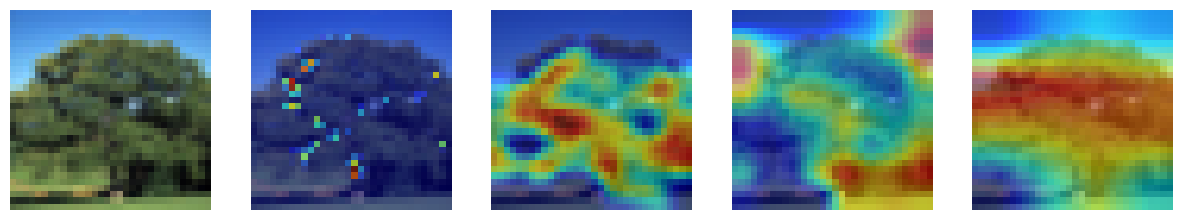

In [175]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt 
import sys

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

# 222222
class L_BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * L_BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * L_BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != L_BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * L_BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * L_BasicBlock.expansion)
            )

    def forward(self, x):
        x_1 = x.clone().detach()
        x_fft = torch.fft.fft2(x, dim=(2, 3))
        x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

        rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
        center_row, center_col = rows // 2, cols // 2
        cutoff_frequency = min(rows, cols) // 3

        high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
        low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)
        
        y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
        dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

        high_pass_mask[:, :, dist <= cutoff_frequency] = 0
        low_pass_mask[:, :, dist <= cutoff_frequency] = 1

        high_pass = x_fft_shifted * high_pass_mask
        low_pass = x_fft_shifted * low_pass_mask

        high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
        low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real
        return nn.ReLU(inplace=True)(self.residual_function(x_1) + self.shortcut(low_pass_ifft))





class L_BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * L_BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * L_BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * L_BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * L_BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * L_BottleNeck.expansion)
            )

    def forward(self, x):
        x_1 = x.clone().detach()
        x_fft = torch.fft.fft2(x, dim=(2, 3))
        x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

        rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
        center_row, center_col = rows // 2, cols // 2
        cutoff_frequency = min(rows, cols) // 3

        high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
        low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)
        
        y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
        dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

        high_pass_mask[:, :, dist <= cutoff_frequency] = 0
        low_pass_mask[:, :, dist <= cutoff_frequency] = 1

        high_pass = x_fft_shifted * high_pass_mask
        low_pass = x_fft_shifted * low_pass_mask

        high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
        low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real
        
        return nn.ReLU(inplace=True)(self.residual_function(x_1) + self.shortcut(low_pass_ifft))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet(nn.Module):

    def __init__(self, block,L_BasicBlock, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(L_BasicBlock, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(L_BasicBlock, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock,L_BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock,L_BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck,L_BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck,L_BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, L_BottleNeck, [3, 8, 36, 3])


# 이미지 전처리 함수 정의
transform = transforms.Compose([
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

# GPU 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



net = resnet18().to(device)
net.load_state_dict((torch.load("o_BLLB.pth")))
# net.load_state_dict((torch.load("original.pth")))
net.eval()


data_iter = iter(testloader)
images, labels = next(data_iter)

# 배치 중 첫 번째 이미지를 선택합니다.
image = images[57].unsqueeze(0).to(device)  # 배치 차원 추가
label = labels[57].item()  # 라벨을 정수로 변환

target_layers1 = [net.conv2_x[-1]]
target_layers2 = [net.conv3_x[-1]]
target_layers3 = [net.conv4_x[-1]]
target_layers4 = [net.conv5_x[-1]]

targets = [ClassifierOutputTarget(label)]

def for_cam(target_layers1, target_layers2, target_layers3, target_layers4, image, targets):
    target_layers_list = [target_layers1, target_layers2, target_layers3, target_layers4]
    num_layers = len(target_layers_list)

    plt.figure(figsize=(15, 5))
    
    # 원본 이미지 시각화
    rgb_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.subplot(1, num_layers + 1, 1)
    plt.imshow(rgb_img)
    plt.axis('off')

    for i, target_layers in enumerate(target_layers_list):
        cam = GradCAM(model=net, target_layers=target_layers, use_cuda=torch.cuda.is_available())
        grayscale_cam = cam(input_tensor=image, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # 배치 차원 제거

        # CAM을 원본 이미지에 오버레이
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        plt.subplot(1, num_layers + 1, i + 2)
        plt.imshow(visualization)
        plt.axis('off')

    plt.show()

for_cam(target_layers1, target_layers2, target_layers3, target_layers4, image, targets)

